In [342]:
from typing import Literal, TypeAlias
from pprint import pprint
import time

import numpy as np
import sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import seaborn as sns
from tqdm import tqdm

In [343]:
Sample: TypeAlias = list[int | float]
Data: TypeAlias = list[Sample]

Target: TypeAlias = int | float
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [344]:
# Activation functions

from abc import ABC, abstractmethod


class ActivationBase(ABC):
    @abstractmethod
    def calc(self, x: Sample) -> list[float]:
        """Apply the activation function to an layer output"""
        pass

    @abstractmethod
    def derivative(self, x: Sample):
        pass

#######################################


class ReLU(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return np.maximum(0, x)

    def derivative(self, x: Sample):
        return self.calc(x=x)


class Sigmoid(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: Sample):
        return x * (1-x)


class Softmax(ActivationBase):
    """returns model 'probabilities' for each class"""

    def calc(self, x: Sample) -> list[float]:
        
        # optimization: make numbers in an array from -inf to 0 because of a np.exp growing
        # and returns an array of floats from 0.0 to 1.0
        max_value = np.max(x)
        x -= max_value

        exp_values = np.exp(x)
        return exp_values / np.sum(exp_values)
    
    def derivative(self, x: Sample):
        pass

In [345]:
# Loss functions


class LossBase(ABC):
    @abstractmethod
    def calc(self, x: Sample, y: Target) -> float:
        """Apply the loss function to an output layer"""
        pass


class MSELoss(LossBase):
    """For regression""" 
    def calc(self, x: Sample, y: Target) -> float:

        loss = (y - x) ** 2

        return np.mean(loss)


class CrossEntropy(LossBase):
    """For classification"""
    def calc(self, x: Sample, y: Target) -> float:
        return -np.sum(y * np.log(x))


In [21]:
a = [1, 100, 22, 99]

f = Softmax()

b = f.calc(a)
print(b)
print(sum(b))

[7.39262147e-44 7.31058579e-01 9.74950551e-35 2.68941421e-01]
1.0


In [346]:
class Dataset:
    def __init__(self, data: Data, targets: Targets) -> None:
        self.data: Data = data
        self._len = len(data)
        self.targets: Targets = targets

    def __len__(self) -> int:
        return self._len
    
    def __getitem__(self, index) -> Sample:
        return self.data[index]
    
    def __iter__(self):
        return iter(self.data)


In [348]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation: ActivationBase) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        
        self.weights = self._init_weights()
        self.bias = self._init_bias()
        self.output = []

        self.activation = activation
    
    def _init_weights(self) -> list[float]:
        scale = 1/max(1., (2+2)/2.)
        limit = np.sqrt(3.0 * scale)

        return np.random.randn(self.n_neurons, self.n_inputs) * 0.1
    
        # weights = np.random.uniform(-limit, limit, size=(self.n_neurons, self.n_inputs))
        # return weights
    
    def _init_bias(self) -> list[float]:
        return np.random.randn(1)
    
    def forward(self, inputs) -> None:
        output = np.matmul( self.weights, inputs.T)
        output += self.bias
        self.output = self.activation.calc(output)


Layers: TypeAlias = list[Linear]

In [378]:
class Model:
    def __init__(self, layers: Layers, loss: LossBase):
        self.layers = layers
        self._layers_len = len(layers)
        self.loss = loss

    def fit(self, dataset: Dataset, n_epoch: int = 1, learning_rate: float = 0.01, verbose: bool = True) -> list[float]:
        losses_by_epoch = []

        range_epoch = range(n_epoch)
        if verbose:
            range_epoch = tqdm(range_epoch, desc="epochs", position=0)

        for epoch in range_epoch:
            epoch_losses = []

            for i,sample in enumerate(dataset):
                sample = np.array(sample)

                # Forward pass
                self.layers[0].forward(inputs=sample) # input layer
                for j in range(1, self._layers_len):
                    self.layers[j].forward(inputs=self.layers[j-1].output)

                target = dataset.targets[i]


                # Calc loss
                output_error = self.calc_loss(target=target)
                epoch_losses.append(output_error)


                # Backward pass
                delta =  self.layers[-2].activation.derivative(x=self.layers[-1].output) * output_error

                for i in range(self._layers_len - 2, -1, -1):
                    error = np.dot(self.layers[i+1].weights.T, delta)
                    delta =  self.layers[i].activation.derivative(x=self.layers[i].output) * error

                    self.layers[i+1].weights += np.dot(delta, self.layers[i].output.T) * learning_rate

            mean_loss = np.mean(epoch_losses)
            losses_by_epoch.append(mean_loss)
        
        return losses_by_epoch
    
    def predict(self, sample: Sample) -> list[float]:
        sample = np.array(sample)
        # sample = sample.reshape(1,len(sample))

        self.layers[0].forward(inputs=sample)
                
        for j in range(1, self._layers_len):
            self.layers[j].forward(inputs=self.layers[j-1].output)
        
        predict = self.layers[-1].output
        return predict
    
    def calc_loss(self, target: Target) -> float:
        output_layer = self.layers[-1]
        output = output_layer.output

        loss = self.loss.calc(x=output, y=target)
        return loss

    
    def set_weights(self, weights: Weights) -> None:
        for w,layer in zip(weights, self.layers):
            layer.weights = w

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.layers]
        return weights

In [136]:
X_train = [
    # [1,2,3,4],
    [4,3,2,1]
]



# X_train = [
#     [[1,2,3], [1,2,3], [1,2,3]], # photo
# ]

y_train = [1,]



train_dataset = Dataset(data=X_train, targets=y_train)
# val_dataset = Dataset(data=X_val, targets=y_val)

In [351]:
# input and output layers must be with equal numbers

layers = [
    Linear(4,13, activation=Sigmoid()),
    Linear(13,4, activation=Sigmoid()),
    Linear(4,2, activation=Sigmoid()),
    Linear(2,4, activation=Sigmoid()),
    Linear(4,2, activation=Sigmoid()),
    Linear(2,100, activation=Sigmoid()),
    Linear(100,1, activation=Sigmoid()),
    Linear(1,1, activation=Sigmoid()),
    Linear(1,1, activation=Softmax()),
]

model = Model(layers=layers, loss=MSELoss())


model.fit(dataset=train_dataset, n_epoch=1, verbose=0)

[0.6666666666666665]

In [353]:
model.layers[1].weights

array([[ 0.0364703 ,  0.28592891,  0.05205459, -0.23562025, -0.13169687,
         0.05773848,  0.15587046, -0.07733469, -0.17965607, -0.00313857,
        -0.09769579, -0.03839707,  0.06037566],
       [-0.00444996,  0.13219194, -0.01261153,  0.11913717,  0.04289459,
         0.04846385, -0.00633721, -0.02220829, -0.0693783 ,  0.09911889,
        -0.1472693 , -0.05517775,  0.08246574],
       [ 0.0108675 ,  0.26054019, -0.09978563,  0.15491572, -0.07706601,
        -0.11919199,  0.13310621,  0.17860847, -0.04446456, -0.11231901,
        -0.10296507, -0.07867678, -0.08930322],
       [-0.14322035,  0.01618757, -0.12069708,  0.00693557, -0.01779432,
        -0.02126548,  0.05125332,  0.14137431, -0.08267617, -0.08961813,
         0.0277973 ,  0.04295598, -0.17798387]])

In [354]:
model.fit(dataset=train_dataset)

epochs: 100%|██████████| 1/1 [00:00<00:00, 15.54it/s]


[0.6666666666666665]

# Load dataset

In [355]:
dataset = load_iris()

In [356]:
dataset.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [357]:
X, y = dataset['data'], dataset['target']

In [358]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [185]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# One-hot encoding

In [359]:
labels = set(y)
labels_len = len(labels)

labels

{0, 1, 2}

In [360]:
y_1 = []

for i in y:
    l = [0] * labels_len
    l[i] = 1
    y_1.append(l)
y_1

[[1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0,

# Split

In [361]:
X_train, X_val, y_train, y_val = train_test_split(X, y_1, train_size=0.8)

In [362]:
train_dataset = Dataset(data=X_train, targets=y_train)
val_dataset = Dataset(data=X_val, targets=y_val)

# Model

In [386]:
layers = [
    Linear(4,4, activation=ReLU()),
    Linear(4,3, activation=ReLU()),
    Linear(3,3, activation=ReLU()),
]

model = Model(layers=layers, loss=MSELoss())

In [387]:
losses = model.fit(dataset=train_dataset, n_epoch=100, verbose=1)

epochs: 100%|██████████| 100/100 [00:00<00:00, 158.58it/s]


# Plots

In [388]:
losses

[0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.22795295322387468,
 0.2279529

/Users/phil/micromamba/envs/bio/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/phil/micromamba/envs/bio/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

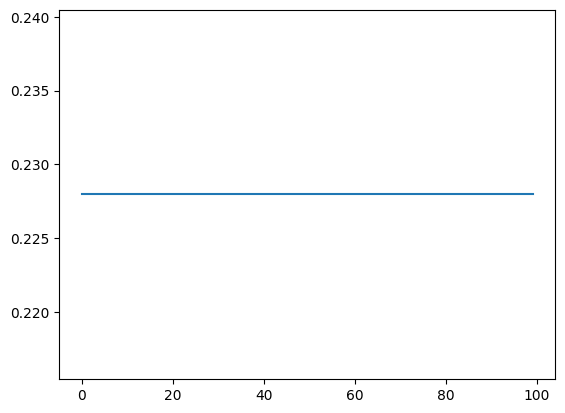

In [389]:
sns.lineplot(losses)

In [371]:
X_val[0]

array([6.4, 2.8, 5.6, 2.2])

In [390]:
model.predict(X_train[1]), y_train[1]

(array([0.25763174, 0.25763174, 0.25763174]), [1, 0, 0])

In [391]:
model.predict(X_val[1]), y_val[1]

(array([0.25763174, 0.25763174, 0.25763174]), [0, 0, 1])

In [392]:
true_count = 0
all_count = 0

for sample,target in zip(X_train, y_train):
    pred = model.predict(sample=sample)

    pred = np.where(pred[0] >= max(pred[0]), 1, 0)
    # print(pred)
    # print(target)

    if list(pred) == target:
        true_count += 1
    all_count += 1 


acc = true_count / all_count
acc

TypeError: 'numpy.float64' object is not iterable

In [393]:
np.argmax([1,0,0])

0